<a href="https://colab.research.google.com/github/maggiedart16/Earth-and-Environmental-Systems-Modeling/blob/main/Soil_Moisture_Model_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Profile-Integrated Soil Moisture Model

### 1. Import Required Libraries, Define Constants

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Meteorological forcing file and parameters
met_forcing_file = 'KONZ_met_forcing_2019-2020.csv'
phi = 39.09 # Latitude at Konza Prairie Biological Station

### Output File Name
model_outp_file = 'konza_base_case.csv'

### Time step
dt = 1

### Soil parameters
Zr = 300.00 #
n = 0.45 # Loam
theta_r = 0.05 # cm^3/cm^3, loam
theta_s = 0.45 # cm^3/cm^3, loam
Ks = 120.5 # mm/day, loam
fmax = 182.88 # mm/day, loam
eta = 4
lambda_f = 2
Kc = 0.8 # Grasses
S_star = 0.3
S_wp = 0.05

S0 = 0.3

### 2. Define Model Functions for Fluxes

Calculation of Extraterrestrial Radiation is from this [FAO website:](https://www.fao.org/4/x0490e/x0490e07.htm#TopOfPage)

In [89]:
def theta2sat(theta, theta_r, theta_s):
  S_e = (theta - theta_r)/(theta_s - theta_r)
  return S_e

def sat2theta(S_e, theta_r, theta_s):
  theta = theta_r + S_e*(theta_s - theta_r)
  return theta

def drainage(S_e, Ks, eta):
  return Ks*S_e**eta

def infiltration(S_e, fmax, lambda_f, P):
  f = fmax*(1 - S_e**lambda_f)
  return np.minimum(f, P)

def ExtraterrestrialRadiation(phi,J):
  # Computes daily extraterrestrial radiation based on latitude, day of year
  phi = phi*np.pi/180.0
  d_r = 1.00011 + 0.034221*np.cos(2*np.pi*J/365)
  delta = 0.409*np.sin(2*np.pi/365*J - 1.39)
  omega_s = np.arccos(-np.tan(phi)*np.tan(delta))
  Ra = (24.0*60.0)/np.pi*0.0820*d_r*(omega_s*np.sin(phi)*np.sin(delta) + np.cos(phi)*np.cos(delta)*np.sin(omega_s))
  Ra = 0.408*Ra # Convert units from MJ/m^2/day to mm/day
  return Ra

def ET_hargreaves(T_avg, T_max, T_min, Kc, phi, J, S_star, S_wp, S_e):
  Ra = ExtraterrestrialRadiation(phi,J)
  ET0 = 0.0023*(T_avg + 17.8)*np.sqrt(np.abs(T_max - T_min))*Ra
  PET = Kc*ET0

  if (S_e > S_star):
    AET = PET
  elif (S_e < S_wp):
    AET = 0.0
  else:
    AET = PET*(S_e - S_wp)/(S_star - S_wp)
  return AET


### 3. Load Meteorological Data

In [90]:
df_forcing = pd.read_csv(met_forcing_file)

P_neon = df_forcing['prcp']
T_mean_neon = df_forcing['tmean']
T_min_neon = df_forcing['tmin']
T_max_neon = df_forcing['tmax']
J_neon = pd.to_datetime(df_forcing['date']).dt.dayofyear

dates_neon = pd.to_datetime(df_forcing['date'])

Nt = P_neon.size

### 4. Initialize Containers to Store Model Outputs

In [91]:
S = np.zeros(Nt)
ET = np.zeros(Nt)
f = np.zeros(Nt)
L = np.zeros(Nt)

### 5. Run the Model

In [92]:
for i in np.arange(Nt):

  P = P_neon[i]
  T_avg = T_mean_neon[i]
  T_max = T_max_neon[i]
  T_min = T_min_neon[i]
  J = J_neon[i]

  if i==0:
    Sim1 = S0
  else:
    Sim1 = S[i-1]

  L[i] = drainage(Sim1, Ks, eta)
  f[i] = infiltration(Sim1, fmax, lambda_f, P)
  ET[i] = ET_hargreaves(T_avg, T_max, T_min, Kc, phi, J, S_star, S_wp, Sim1)
  S[i] = np.clip(Sim1 + dt/(n*Zr)*(f[i] - L[i] - ET[i]), 0.0, 1.0)


### 6. Save the Outputs

In [93]:
model_data = {
    'date': dates_neon,
    's_e': S,
    'soimoi': sat2theta(S, theta_r, theta_s),
    'qinf': f,
    'qrch': L,
    'ET': ET,
}

df_model_output = pd.DataFrame(model_data)
df_model_output.to_csv(model_outp_file)

### 7. Plot Model Output

Text(0, 0.5, 'Mean Temperature [°C]')

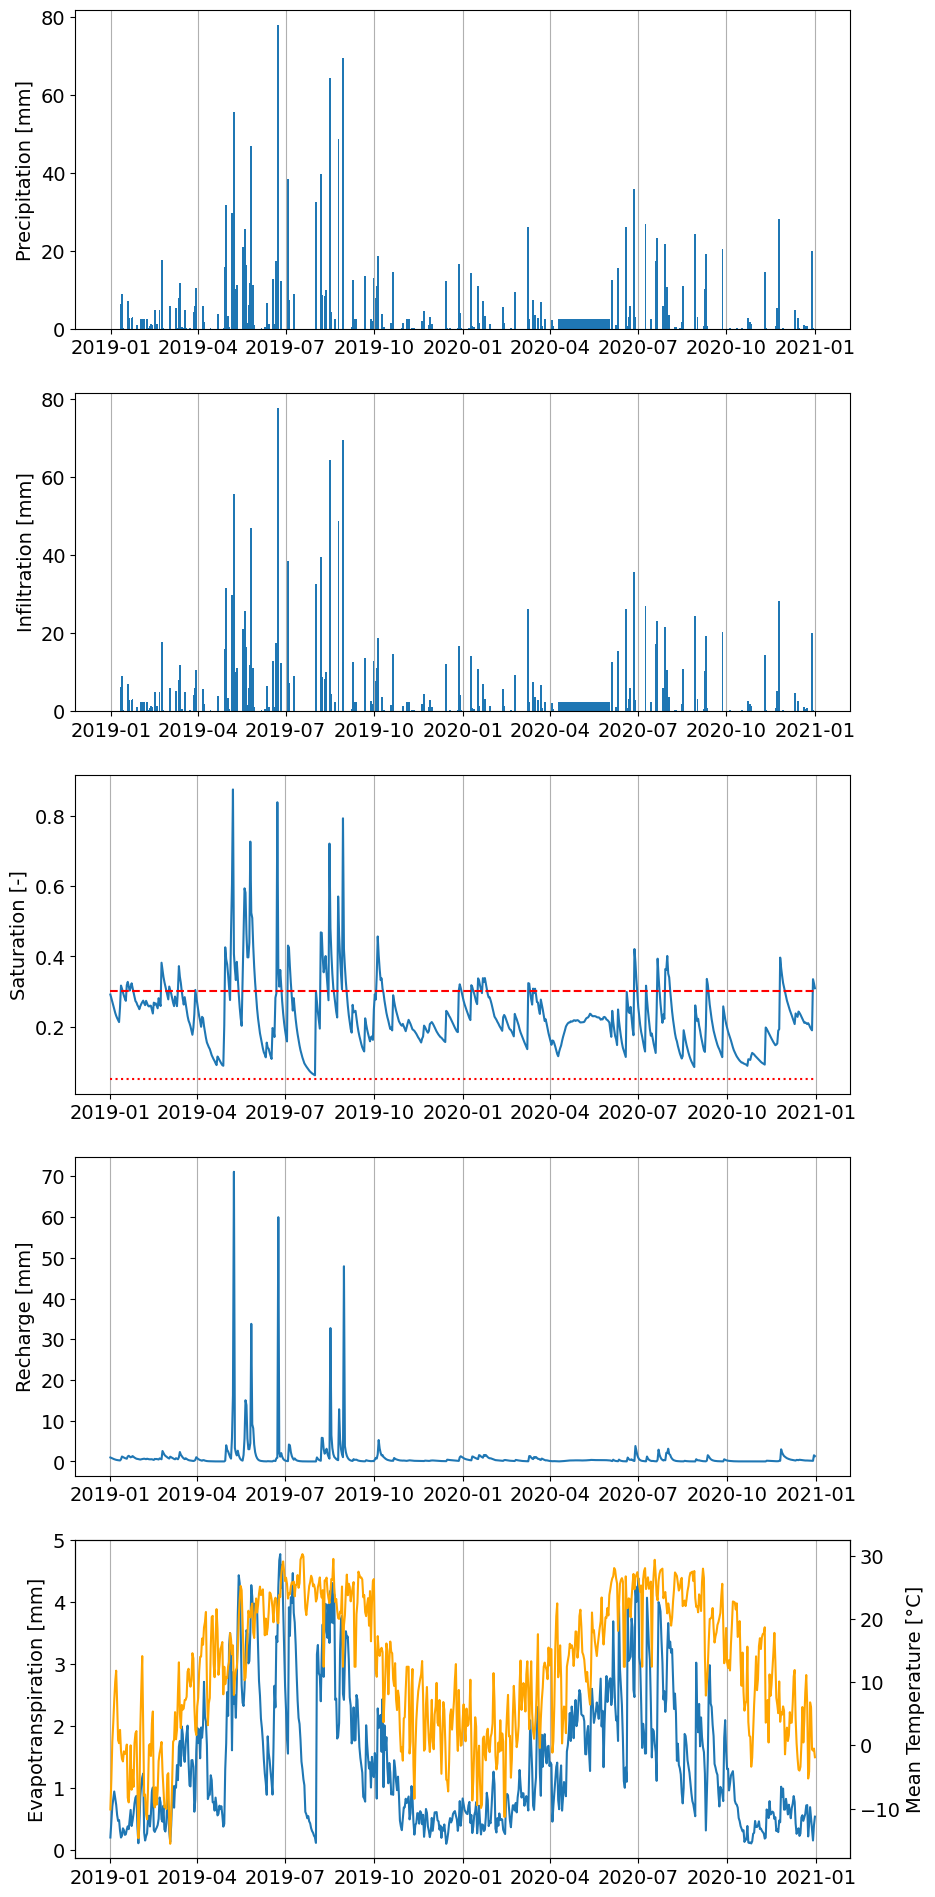

In [94]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(5,figsize=(10,24))
ax[0].bar(dates_neon,P_neon,width=2)
ax[0].grid(axis='x')
ax[0].set_ylabel('Precipitation [mm]')

ax[1].bar(dates_neon,f,width=2)
ax[1].grid(axis='x')
ax[1].set_ylabel('Infiltration [mm]')

ax[2].plot(dates_neon,S)
ax[2].hlines(S_star,dates_neon.min(),dates_neon.max(),colors='red',linestyle='dashed')
ax[2].hlines(S_wp,dates_neon.min(),dates_neon.max(),colors='red',linestyle='dotted')
ax[2].grid(axis='x')
ax[2].set_ylabel('Saturation [-]')

ax[3].plot(dates_neon,L)
ax[3].grid(axis='x')
ax[3].set_ylabel('Recharge [mm]')

ax[4].plot(dates_neon,ET)
ax[4].grid(axis='x')
ax[4].set_ylabel('Evapotranspiration [mm]')

ax4 = ax[4].twinx()
ax4.plot(dates_neon,T_mean_neon,color='orange')
ax4.set_ylabel('Mean Temperature [°C]')

